In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import joblib
import os

In [2]:
# Загрузка данных
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
student_assessment = pd.read_csv('studentAssessment.csv')
student_registration = pd.read_csv('studentRegistration.csv')

In [3]:
# Выводим основные сведения о данных
print(assessments.head())
print(assessments.info())
print(courses.head())
print(courses.info())
print(student_assessment.head())
print(student_assessment.info())
print(student_registration.head())
print(student_registration.info())

  code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753             TMA   54.0    20.0
2         AAA             2013J           1754             TMA  117.0    20.0
3         AAA             2013J           1755             TMA  166.0    20.0
4         AAA             2013J           1756             TMA  215.0    30.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memo

In [4]:
# Заполнение пропущенных значений
assessments['date'].fillna(-1, inplace=True)
student_assessment = student_assessment.dropna(subset=['score'])
student_registration = student_registration.dropna(subset=['date_registration'])

# Проверка на дубликаты
print(assessments.duplicated().sum())
print(courses.duplicated().sum())
print(student_assessment.duplicated().sum())
print(student_registration.duplicated().sum())

# Удаление дубликатов
assessments = assessments.drop_duplicates()
courses = courses.drop_duplicates()
student_assessment = student_assessment.drop_duplicates()
student_registration = student_registration.drop_duplicates()

0
0
0
0


In [5]:
# Объединение данных по экзаменам и результатам студентов
exams = assessments[assessments['assessment_type'] == 'Exam']
merged_data = student_assessment.merge(exams, on='id_assessment')

# Фильтрация успешных сдач экзаменов
successful_exams = merged_data[merged_data['score'] >= 40]

# Подсчет успешных сдач для каждого студента по каждому курсу
successful_courses = successful_exams.groupby(['id_student', 'code_module', 'code_presentation']).size().reset_index(name='num_successful_exams')

# Подсчет числа успешных сдач для каждого студента
student_success_count = successful_courses.groupby('id_student').size().reset_index(name='num_successful_courses')

# Выбор студентов, успешно сдавших только один курс
students_single_course = student_success_count[student_success_count['num_successful_courses'] == 1]

# Количество таких студентов
num_students_single_course = students_single_course.shape[0]
print(f"Количество студентов, успешно сдавших только один курс: {num_students_single_course}")

Количество студентов, успешно сдавших только один курс: 3802


In [6]:
# Рассчитаем количество попыток сдачи и успешных сдач для каждого экзамена
total_attempts = merged_data.groupby(['code_module', 'code_presentation', 'id_assessment']).size()
successful_attempts = merged_data[merged_data['score'] >= 40].groupby(['code_module', 'code_presentation', 'id_assessment']).size()

# Рассчитаем завершаемость
completion_rate = (successful_attempts / total_attempts).reset_index(name='completion_rate')

# Найдем самый сложный и самый простой экзамен
hardest_exam = completion_rate.loc[completion_rate['completion_rate'].idxmin()]
easiest_exam = completion_rate.loc[completion_rate['completion_rate'].idxmax()]

# Вывод результатов для экзаменов
print("Самый сложный экзамен:")
print(hardest_exam)

print("\nСамый простой экзамен:")
print(easiest_exam)

# Рассчитаем завершаемость на уровне курсов
course_completion_rate = completion_rate.groupby(['code_module', 'code_presentation'])['completion_rate'].mean().reset_index(name='course_completion_rate')

# Найдем курс с самой низкой и самой высокой завершаемостью
hardest_course = course_completion_rate.loc[course_completion_rate['course_completion_rate'].idxmin()]
easiest_course = course_completion_rate.loc[course_completion_rate['course_completion_rate'].idxmax()]

# Вывод результатов для курсов
print("Курс с самой низкой завершаемостью:")
print(hardest_course)

print("\nКурс с самой высокой завершаемостью:")
print(easiest_course)

Самый сложный экзамен:
code_module               DDD
code_presentation       2013B
id_assessment           25340
completion_rate      0.837209
Name: 2, dtype: object

Самый простой экзамен:
code_module               DDD
code_presentation       2014B
id_assessment           25361
completion_rate      0.925573
Name: 4, dtype: object
Курс с самой низкой завершаемостью:
code_module                    DDD
code_presentation            2013B
course_completion_rate    0.837209
Name: 2, dtype: object

Курс с самой высокой завершаемостью:
code_module                    DDD
code_presentation            2014B
course_completion_rate    0.925573
Name: 4, dtype: object


In [7]:
# Найдем дату последнего успешного экзамена для каждого студента по каждому предмету
last_successful_exams = successful_exams.groupby(['id_student', 'code_module', 'code_presentation'])['date_submitted'].max().reset_index()

# Определим день сдачи экзамена (дата последнего успешного экзамена)
last_successful_exams['last_successful_date'] = last_successful_exams.groupby(['code_module', 'code_presentation'])['date_submitted'].transform('max')

# Приведем данные к необходимому формату
last_successful_exams = last_successful_exams.drop_duplicates(subset=['code_module', 'code_presentation', 'id_student'])

# Посчитаем средний срок сдачи экзаменов по предметам
average_completion_time = last_successful_exams.groupby(['code_module', 'code_presentation'])['last_successful_date'].mean().reset_index(name='average_completion_time')

# Вывод результатов
print(average_completion_time)

  code_module code_presentation  average_completion_time
0         CCC             2014B                    266.0
1         CCC             2014J                    285.0
2         DDD             2013B                    241.0
3         DDD             2013J                    255.0
4         DDD             2014B                    251.0
5         DDD             2014J                    279.0


In [8]:
# Определение самых популярных предметов по количеству регистраций
popular_courses = student_registration.groupby(['code_module', 'code_presentation']).size().reset_index(name='num_registrations').sort_values(by='num_registrations', ascending=False).head(3)
print("Топ-3 самых популярных предмета:")
print(popular_courses)

# Определение предметов с самым большим оттоком
student_registration['unregistered'] = student_registration['date_unregistration'].notna().astype(int)
dropout_courses = student_registration.groupby(['code_module', 'code_presentation'])['unregistered'].sum().reset_index(name='num_dropouts').sort_values(by='num_dropouts', ascending=False).head(3)
print("Топ-3 предмета с самым большим оттоком:")
print(dropout_courses)

Топ-3 самых популярных предмета:
   code_module code_presentation  num_registrations
7          CCC             2014J               2495
18         FFF             2014J               2363
5          BBB             2014J               2291
Топ-3 предмета с самым большим оттоком:
   code_module code_presentation  num_dropouts
7          CCC             2014J          1047
6          CCC             2014B           893
18         FFF             2014J           829


In [9]:
# Определение периодов для анализа (начало 2013 до конца 2014)
valid_years = ['2013A', '2013B', '2014A', '2014B']

# Фильтрация данных регистраций и экзаменов по указанным годам
filtered_registration = student_registration[student_registration['code_presentation'].isin(valid_years)]
filtered_exams = successful_exams[successful_exams['code_presentation'].isin(valid_years)]

# Определяем завершаемость курсов для каждого семестра
total_attempts = filtered_registration.groupby(['code_module', 'code_presentation']).size()
successful_attempts = filtered_exams.groupby(['code_module', 'code_presentation']).size()

# Рассчитаем завершаемость
completion_rate = (successful_attempts / total_attempts).reset_index(name='completion_rate')

# Добавляем информацию о длительности семестра
semester_lengths = courses[['code_module', 'code_presentation', 'module_presentation_length']].drop_duplicates()
completion_rate = completion_rate.merge(semester_lengths, on=['code_module', 'code_presentation'])

# Рассчитываем завершаемость для каждого семестра
completion_rate = completion_rate.groupby('code_presentation')['completion_rate'].mean().reset_index(name='average_completion_rate')

# Определение даты последнего успешного экзамена для каждого студента по каждому семестру
last_successful_exams = filtered_exams.groupby(['id_student', 'code_module', 'code_presentation'])['date_submitted'].max().reset_index()

# Рассчитаем среднее время сдачи экзамена по семестрам
average_completion_time = last_successful_exams.groupby(['code_module', 'code_presentation'])['date_submitted'].max().reset_index()
average_completion_time = average_completion_time.merge(courses[['code_module', 'code_presentation', 'module_presentation_length']], on=['code_module', 'code_presentation'])
average_completion_time['average_completion_time'] = average_completion_time['date_submitted'] / average_completion_time['module_presentation_length']

# Рассчитываем среднее время сдачи для каждого семестра
average_completion_time = average_completion_time.groupby('code_presentation')['average_completion_time'].mean().reset_index(name='average_completion_time')

# Найдем семестр с самой низкой завершаемостью
lowest_completion_rate_semester = completion_rate.loc[completion_rate['average_completion_rate'].idxmin()]

# Найдем семестр с самым длинным средним сроком сдачи экзаменов
longest_completion_time_semester = average_completion_time.loc[average_completion_time['average_completion_time'].idxmax()]

print("Семестр с самой низкой завершаемостью:")
print(lowest_completion_rate_semester)

print("\nСеместр с самым длинным средним сроком сдачи экзаменов:")
print(longest_completion_time_semester)

Семестр с самой низкой завершаемостью:
code_presentation             2014B
average_completion_rate    0.369891
Name: 1, dtype: object

Семестр с самым длинным средним сроком сдачи экзаменов:
code_presentation             2014B
average_completion_time    1.072614
Name: 1, dtype: object


Итоговая сводная таблица по кластерам:
   cluster     id_student  average_submission_time  average_score  \
0        0  753815.948419               232.301581      67.731697   
1        1  765546.764922               241.673554      86.692837   
2        2  716291.441903               242.243824      56.014639   
3        3  703972.288920               238.250351      67.694951   

   completion_rate  
0         1.000000  
1         0.999694  
2         0.999543  
3         0.499299  


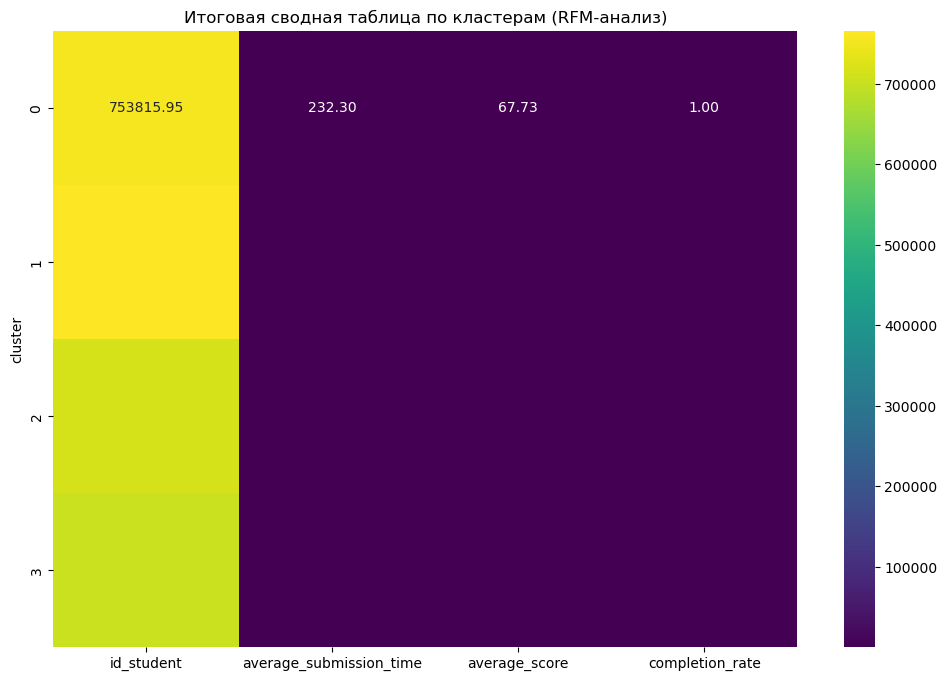

Границы для Recency (R): {1: (233.5, 259.0), 0: (229.0, 237.0), 2: (236.0, 285.0), 3: (229.0, 251.0)}
Границы для Frequency (F): {1: (0.6666666666666666, 1.0), 0: (1.0, 1.0), 2: (0.5, 1.0), 3: (0.3333333333333333, 0.5)}
Границы для Monetary (M): {1: (71.5, 100.0), 0: (40.0, 100.0), 2: (40.0, 72.0), 3: (32.0, 100.0)}


In [10]:
# Игнорировать предупреждения от joblib
warnings.filterwarnings('ignore', category=UserWarning, module='joblib')

# Явное указание числа процессов
joblib.parallel_backend('loky', n_jobs=1)

# Установите количество ядер в переменной окружения (опционально)
os.environ['LOKY_MAX_CPU_COUNT'] = '1'

# Расчет метрик для каждого студента
# Recency (R) - среднее время сдачи одного экзамена
recency = merged_data.groupby('id_student')['date_submitted'].mean().reset_index(name='average_submission_time')

# Monetary (M) - среднее количество баллов
monetary = merged_data.groupby('id_student')['score'].mean().reset_index(name='average_score')

# Frequency (F) - завершаемость курсов
course_attempts = student_registration.groupby('id_student')['code_module'].nunique().reset_index(name='total_courses')
successful_courses = successful_exams.groupby('id_student')['code_module'].nunique().reset_index(name='completed_courses')
frequency = successful_courses.merge(course_attempts, on='id_student')
frequency['completion_rate'] = frequency['completed_courses'] / frequency['total_courses']

# Объединяем все метрики
rfm_data = recency.merge(monetary, on='id_student').merge(frequency[['id_student', 'completion_rate']], on='id_student')

# Заполняем пропуски значениями 0 (если есть студенты без данных)
rfm_data.fillna(0, inplace=True)

# Нормализация данных
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['average_submission_time', 'completion_rate', 'average_score']])

# Кластеризация
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)  # Указываем n_init
rfm_data['cluster'] = kmeans.fit_predict(rfm_scaled)

# Анализ кластеров
cluster_summary = rfm_data.groupby('cluster').mean().reset_index()

# Вывод итоговой сводной таблицы
print("Итоговая сводная таблица по кластерам:")
print(cluster_summary)

# Визуализация итоговой сводной таблицы с помощью heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary.set_index('cluster'), annot=True, cmap='viridis', fmt=".2f")
plt.title("Итоговая сводная таблица по кластерам (RFM-анализ)")
plt.show()

# Определение границ для каждого сегмента
def define_boundaries(df, metric):
    """ Определение границ для метрики в кластерах """
    boundaries = {}
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        min_val = cluster_data[metric].min()
        max_val = cluster_data[metric].max()
        boundaries[cluster] = (min_val, max_val)
    return boundaries

recency_boundaries = define_boundaries(rfm_data, 'average_submission_time')
frequency_boundaries = define_boundaries(rfm_data, 'completion_rate')
monetary_boundaries = define_boundaries(rfm_data, 'average_score')

print("Границы для Recency (R):", recency_boundaries)
print("Границы для Frequency (F):", frequency_boundaries)
print("Границы для Monetary (M):", monetary_boundaries)
